In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning) 

import pandas as pd
import numpy as np

random_seed = 3

In [2]:
sales = pd.read_csv('data/storesalesdata.csv')
sales.shape

(116232, 13)

In [3]:
info = pd.read_csv('data/storeinformation.csv')
info.shape

(95, 6)

In [4]:
demo = pd.read_csv('data/storedemographicdata.csv')
demo.shape

(95, 45)

---

# Data Preparation

In [5]:
info.Type.value_counts()

Existing    85
New         10
Name: Type, dtype: int64

In [6]:
stores_exist = info[info.Type == 'Existing']
stores_exist.shape

(85, 6)

In [7]:
stores_new = info[info.Type == 'New']
stores_new.shape

(10, 6)

In [8]:
pd.merge(sales, stores_new, on='Store').shape[0]

0

The sales data only includes sales from existing stores - that makes intuitive sense!

# Task 1: Segmentation - Determining Store Format

Your company currently has 85 grocery stores and is planning to open 10 new stores at the beginning of the year. Currently, all stores use the same store format for selling their products. Up until now, the company has treated all stores similarly, shipping the same amount of product to each store. This is beginning to cause problems as stores are suffering from product surpluses in some product categories and shortages in others. You've been asked to provide analytical support to make decisions about store formats and inventory planning.

To remedy the product surplus and shortages, the company wants to introduce different store formats. Each store format will have a different product selection in order to better match local demand. The actual building sizes will not change, just the product selection and internal layouts. The terms formats and segments will be used interchangeably throughout this project. You’ve been asked to:

* Determine the optimal number of store formats based on sales data.
    * Sum sales data by StoreID and Year
    * Use percentage sales per category per store for clustering (category sales as a percentage of total store sales).
    * Use only 2015 sales data.
    * Use a K-means clustering model.
* Segment the 85 current stores into the different store formats.
* Use the StoreSalesData.csv and StoreInformation.csv files.

**Note:** PCA is not used in this project.

## Task 1 Submission

1. What is the optimal number of store formats? How did you arrive at that number?
2. How many stores fall into each store format?

Based on the results of the clustering model, what is one way that the clusters differ from one another?
Please provide a map created in Tableau that shows the location of the existing stores, uses color to show cluster, and size to show total sales. Make sure to include a legend! Feel free to simply copy and paste the map into the submission template.

Let's filter on sales data from 2015 only.

In [9]:
sales_2015 = sales[sales.Year == 2015]
sales_2015.shape

(30933, 13)

For the next step, we sum the sales data by StoreID, based on year 2015.

In [10]:
sales_2015_sum = sales_2015.groupby(['Store']).agg(sum).iloc[:,3:]
sales_2015_sum.shape

(85, 9)

In [11]:
sales_2015_sum.head()

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Store,,,,,,,,,
S0001,10845787.65,2423389.38,1814872.88,2531382.34,2284388.70,159142.23,1023812.90,835599.06,1590570.68
S0002,7931072.94,1844188.83,1366677.52,1991807.66,1755293.15,128935.92,689786.42,514864.68,1111992.45
S0003,12741875.44,3095321.58,2087437.15,3468989.12,3792143.03,291259.69,1262874.27,1091930.44,2408831.27
S0004,12688533.89,2710746.38,2240847.44,3565375.84,2802811.88,170822.64,1166388.77,962155.82,1606208.31
S0005,12248085.57,2957003.74,2402445.89,2834435.52,3648309.02,247017.36,984736.25,629055.94,1874796.88


We will use the percentage sales per category per store for clustering.

In [12]:
sales_2015_perc = sales_2015_sum.div(sales_2015_sum.sum(axis=1), axis=0)

In [13]:
sales_2015_perc.head()

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Store,,,,,,,,,
S0001,0.461347,0.103084,0.077199,0.107677,0.097171,0.006769,0.043550,0.035544,0.067658
S0002,0.457528,0.106388,0.078841,0.114903,0.101259,0.007438,0.039792,0.029702,0.064149
S0003,0.421349,0.102356,0.069027,0.114713,0.125399,0.009631,0.041761,0.036108,0.079655
S0004,0.454560,0.097111,0.080277,0.127728,0.100409,0.006120,0.041785,0.034469,0.057542
S0005,0.440169,0.106268,0.086339,0.101863,0.131112,0.008877,0.035389,0.022607,0.067376


In [14]:
sales_2015_perc.describe().T

,count,mean,std,min,25%,50%,75%,max
Dry_Grocery,85.0,0.448090,0.016482,0.413319,0.438117,0.445549,0.459835,0.494458
Dairy,85.0,0.102356,0.005927,0.090722,0.098192,0.101905,0.106080,0.122190
Frozen_Food,85.0,0.078934,0.005052,0.063373,0.075503,0.078841,0.082141,0.094408
Meat,85.0,0.111315,0.012313,0.086198,0.104836,0.109581,0.117167,0.159218
Produce,85.0,0.109626,0.014413,0.073948,0.100387,0.109022,0.117936,0.148003
Floral,85.0,0.008158,0.002305,0.003532,0.006509,0.007912,0.009299,0.016254
Deli,85.0,0.040461,0.004972,0.027159,0.037658,0.040397,0.043480,0.051568
Bakery,85.0,0.027986,0.006671,0.015882,0.022743,0.028239,0.031726,0.047304
General_Merchandise,85.0,0.073074,0.014307,0.049732,0.063327,0.068768,0.079655,0.108992


Finally, let's standardize the fields using z-score.

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [16]:
sales_2015_scaled = pd.DataFrame(scaler.fit_transform(sales_2015_perc), index=sales_2015_perc.index, columns=sales_2015_perc.columns)
sales_2015_scaled.shape

(85, 9)

In [17]:
sales_2015_scaled.head()

,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
Store,,,,,,,,,
S0001,0.809075,0.123437,-0.345390,-0.297199,-0.869242,-0.605960,0.624934,1.139692,-0.380775
S0002,0.575979,0.684180,-0.018513,0.293169,-0.583907,-0.314143,-0.135248,0.258721,-0.627521
S0003,-1.632047,-0.000024,-1.972473,0.277587,1.100833,0.643122,0.262976,1.224759,0.462742
S0004,0.394833,-0.890256,0.267452,1.340907,-0.643243,-0.889562,0.267921,0.977567,-1.092061
S0005,-0.483467,0.663894,1.474338,-0.772215,1.499572,0.313982,-1.026059,-0.811087,-0.400609


## K-means clustering model

In [18]:
from sklearn.cluster import KMeans

### Decide on optimum number of clusters `K`

The main input for k-means clustering is the number of clusters. This is derived using the concept of minimizing within cluster sum of square (WCSS). A scree plot is created which plots the number of clusters in the X axis and the WCSS for each cluster number in the y-axis.

As the number of clusters increase, the WCSS keeps decreasing. The decrease of WCSS is initially steep and then the rate of decrease slows down resulting in an elbow plot. The number of clusters at the elbow formation usually gives an indication on the optimum number of clusters. This combined with specific knowledge of the business requirement should be used to decide on the optimum number of clusters.

In [19]:
X1 = sales_2015_scaled.iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

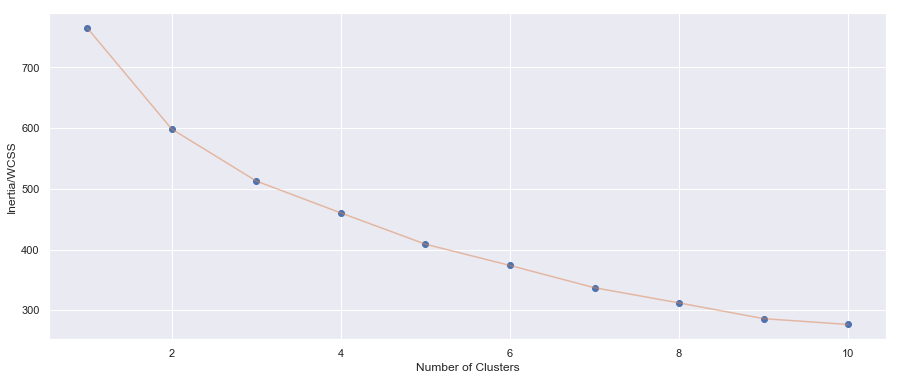

In [20]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia/WCSS')
#plt.savefig('elbow.png')
plt.show()

In [21]:
from sklearn.metrics import silhouette_score, calinski_harabaz_score

In [22]:
def get_score(n_clusters, data, method):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data)
    preds = kmeans.predict(data)
    centers = kmeans.cluster_centers_
    
    if method == 'sil':
        score = silhouette_score(data, preds)
        print("silhouette coefficient for `{}` clusters => {:.4f}".format(n_clusters, score))
        
    elif method == 'ch':
        score = calinski_harabaz_score(data, preds)
        print("calinski harabaz score for `{}` clusters => {:.4f}".format(n_clusters, score))
        
    else:
        print('Sorry, please choose a different metric, for example sil or ch.')

In [23]:
clusters_range = range(2,11)
for i in clusters_range:
    get_score(i, sales_2015_scaled, 'sil')

print()

for i in clusters_range:
    get_score(i, sales_2015_scaled, 'ch')

silhouette coefficient for `2` clusters => 0.1897
silhouette coefficient for `3` clusters => 0.1859
silhouette coefficient for `4` clusters => 0.1900
silhouette coefficient for `5` clusters => 0.1875
silhouette coefficient for `6` clusters => 0.1896
silhouette coefficient for `7` clusters => 0.1842
silhouette coefficient for `8` clusters => 0.2071
silhouette coefficient for `9` clusters => 0.1933
silhouette coefficient for `10` clusters => 0.2175

calinski harabaz score for `2` clusters => 23.0636
calinski harabaz score for `3` clusters => 20.1706
calinski harabaz score for `4` clusters => 18.0870
calinski harabaz score for `5` clusters => 17.5966
calinski harabaz score for `6` clusters => 16.1231
calinski harabaz score for `7` clusters => 15.8650
calinski harabaz score for `8` clusters => 16.1190
calinski harabaz score for `9` clusters => 15.4935
calinski harabaz score for `10` clusters => 15.8214


This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

* Based on Elbow method, we could choose 3 or 4 clusters.

The silhouette of a sample is a mean value of silhouette values from this sample. Therefore, the silhouette distance shows to which extent the distance between the objects of the same class differ from the mean distance between the objects from different clusters. This coefficient takes values in the  [−1,1]  range. Values close to -1 correspond to bad clustering results while values closer to 1 correspond to dense, well-defined clusters. Therefore, the higher the silhouette value is, the better the results from clustering.

* Based on silhouette coefficient, 3 has the best score.

Calinski Harabaz score is also known as the Variance Ratio Criterion. The score is defined as ratio between the within-cluster dispersion and the between-cluster dispersion. There is no "acceptable" cut-off value. You simply compare CH values by eye. The higher the value, the "better" is the solution. If on the line-plot of CH values there appears that one solution give peak or at least abrupt elbow, choose it. If, on the contrary, the line is smooth - horizontal or ascending or descending - then there is no reason to prefer one solution to others. CH criterion is based on ANOVA ideology. Hence, it implies that the clustered objects lie in Euclidean space of scale (not ordinal or binary or nominal) variables. If the data clustered were not objects X variables but a matrix of dissimilarities between objects then the dissimilarity measure should be (squared) euclidean distance (or, at worse, other metric distance approaching euclidean distance by properties).

* Based on Calinski Harabaz Score, 3 has the best score.

We cannot use the adjusted rand score here, since we are not working with a dataset that has a target variable, so we cannot compute true from predicted. See documentation: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html

**The optimal number of store formats is, in this case, 3.**

In [24]:
kmeans = KMeans(n_clusters = 3,
                init = 'k-means++',            # selects initial cluster centers for k-mean clustering in a smart way to speed up convergence
                n_init = 50,                   # number of iterations for clustering)
                max_iter = 500,                # maximum number of iterations of the k-means algorithm for a single run
                tol = 0.0001,                  # relative tolerance with regards to inertia to declare convergence
                random_state = random_seed,
                n_jobs = 1,                    # number of cpu cores to use
               )

In [25]:
kmeans.fit(sales_2015_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=3, n_init=50, n_jobs=1, precompute_distances='auto',
    random_state=3, tol=0.0001, verbose=0)

In [26]:
clusters = kmeans.predict(sales_2015_scaled) + 1
clusters

array([2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 1, 3, 3, 2,
       3, 1, 2, 3, 3, 2, 2, 2, 1, 1, 3, 3, 2, 1, 1, 3, 2, 2, 2, 2, 3, 2,
       1, 3, 1, 1, 3, 3, 3, 3, 2, 3, 1, 3, 2, 2, 2, 2, 2, 1, 3, 3, 3, 1,
       2, 3, 3, 1, 2, 2, 3, 2, 2, 3, 3, 3, 2, 1, 3, 2, 3, 1, 3],
      dtype=int32)

In [27]:
sales_2015_scaled['cluster'] = clusters
sales_2015_perc['cluster'] = clusters

In [28]:
agg = {
    'Store': 'count',
    'Dry_Grocery': 'mean',
    'Dairy': 'mean',
    'Frozen_Food': 'mean',
    'Meat': 'mean',
    'Produce': 'mean',
    'Floral': 'mean',
    'Deli': 'mean',
    'Bakery': 'mean',
    'General_Merchandise': 'mean',
}

In [29]:
agg = round(sales_2015_perc.reset_index().groupby(['cluster']).agg(agg), 3)
agg

,Store,Dry_Grocery,Dairy,Frozen_Food,Meat,Produce,Floral,Deli,Bakery,General_Merchandise
cluster,,,,,,,,,,
1,17,0.458,0.099,0.080,0.103,0.101,0.007,0.038,0.022,0.091
2,35,0.454,0.100,0.077,0.120,0.101,0.007,0.044,0.029,0.069
3,33,0.437,0.106,0.081,0.106,0.123,0.010,0.038,0.030,0.068


In [30]:
centroids = kmeans.cluster_centers_
centroids

array([[ 0.5857416 , -0.49736975,  0.29863928, -0.63855412, -0.56764269,
        -0.33273911, -0.56178673, -0.93037025,  1.22981515],
       [ 0.33793645, -0.40106051, -0.47531254,  0.69223838, -0.57716656,
        -0.55295567,  0.74220778,  0.10276315, -0.28638552],
       [-0.66016311,  0.68158798,  0.35027488, -0.4052401 ,  0.90456834,
         0.75787919, -0.49778478,  0.37029042, -0.32979892]])

Let's look at the distances between the three cluster centers.

In [31]:
from sklearn.metrics.pairwise import euclidean_distances

dists = euclidean_distances(centroids)
tri_dists = dists[np.triu_indices(3, 1)]
max_dist, avg_dist, min_dist = tri_dists.max(), tri_dists.mean(), tri_dists.min()

In [32]:
print('Max distance: ' + str(max_dist))
print('Mean distance: ' + str(avg_dist))
print('Min distance: ' + str(min_dist))

Max distance: 3.2379600984807366
Mean distance: 3.0272658531439003
Min distance: 2.748801515304544


Now let's look at some statistics from all the datapoint distances to the respective cluster centers.

In [33]:
alldist = pd.DataFrame(kmeans.fit_transform(sales_2015_perc), columns=['2', '1', '3'])
alldist['cluster'] = clusters

In [34]:
alldist.head()

,2,1,3,cluster
0,0.016828,1.000658,1.000411,2
1,0.011356,1.000485,1.000473,2
2,1.000944,0.025631,2.000625,3
3,0.016065,1.000748,1.000936,2
4,1.000821,0.014261,2.000454,3


In [35]:
alldist_new = pd.DataFrame(alldist.query('cluster==1')['1'].append(alldist.query('cluster==2')['2']).append(alldist.query('cluster==3')['3'])).sort_index()
alldist_new['cluster'] = clusters

In [36]:
alldist_new.head()

,0,cluster
0,0.016828,2
1,0.011356,2
2,2.000625,3
3,0.016065,2
4,2.000454,3


In [37]:
agg = {
    'mean',
    'max',
    'min'
}
alldist_new.groupby(['cluster']).agg(agg)[0]

,min,mean,max
cluster,,,
1,2.000148,2.000552,2.001111
2,0.010532,0.022871,0.053213
3,2.000149,2.000513,2.001318


Finally, let's prepare a file for Tableau with all existing stores, the total sales per store and the cluster assigned.

In [38]:
all_sales = sales.groupby(['Store']).agg(sum).iloc[:,3:]
all_sales['cluster'] = sales_2015_scaled['cluster'].values
all_sales['Total_Sales'] = all_sales.iloc[:,:9].sum(axis=1)
all_sales = all_sales.iloc[:,9:]

In [39]:
all_sales.to_csv('all_sales.csv', index=True)